In [1]:
%matplotlib inline

In [2]:
import os

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from numpy import zeros, mean

from scipy.stats import pearsonr

import pylab
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #RobustScaler
#from sklearn import linear_model, kernel_ridge
from sklearn.model_selection import cross_val_score
#from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
#from sklearn.metrics import matthews_corrcoef

#import tabulate

from mtds.reader import read_vasp_from_dir
from mtds.helper import  filter_element_or, get_row_group_density_vec, aggregate_data, row_group_limits, show_correlations
from mtds.plots import display_cv, data4plotly

In [3]:
# Read local data of raw (downloaded) VASP format(*.vasp).
PATH_BASE = os.path.join(os.getcwd(), 'database')
path_bin = os.path.join(PATH_BASE)
path_bin_all = os.path.join(PATH_BASE)

# bin_mts and bin_mts_all are both list of dictionaries
bin_mts = read_vasp_from_dir(path_bin)          
bin_mts_all = read_vasp_from_dir(path_bin_all)

In [4]:
#"""Filter Materials."""
def mt_filter(mt):
    #"""Use this to filter data you don't need."""
    return mt['Tensile_modulus']

def get_targets_mine(mt):
    #"""Return user-defined target."""
    return mt[MyTarget]*units #  'Specific_heat_capacity' 'Thermal_conductivity' 'Tensile_modulus' 'Shear_modulus' 'Thermal_expansion_coefficient'

def get_specific_features_mine(mt):
    #"""Return specific features."""
    target_features = ['Poisson_ratio', 'Tensile_strength,_ultimate', 'Tensile_strength,_yield','Density']
    features = zeros(len(target_features)) 
    for i in range(len(target_features)):
        features[i] = mt[target_features[i]]   
    return features

def get_features_mine(mt):
    # Get the boundary of rows and groups of periodic table.
    rg_limits = row_group_limits()
    rg_features = get_row_group_density_vec(mt, rg_limits)
    spec_features = get_specific_features_mine(mt)
    return np.concatenate((rg_features, spec_features))


In [5]:
#"""return mt # use all available."""
mts_all = bin_mts_all
print('Number of All Materials:{}'.format(len(mts_all)))

#"""Filter materials for some condition."""
mts_used = [mt for mt in mts_all if mt_filter(mt)]
print('Number of USED Materials:{}'.format(len(mts_used)))

mts_train, mts_test = train_test_split(bin_mts, test_size=0.10, random_state=0)
print('Number of Training Materials: {} [Filtered]'.format(len(mts_train)))
print('Number of Testing  Materials: {} [Filtered]'.format(len(mts_test)))


#"""Define functions for fetching features and targets."""
units = 1e-9
MyTarget = 'Shear_modulus'

Number of All Materials:711
Number of USED Materials:711
Number of Training Materials: 639 [Filtered]
Number of Testing  Materials: 72 [Filtered]


In [6]:
#"""A shortcut for feature target pairing."""
collecting = lambda x, y, z: [[y(mt) for mt in x], [z(mt) for mt in x]]
#features_train, targets_train = collecting(mts_train, get_features_mine, get_targets_mine)
#features_test, targets_test = collecting(mts_test, get_features_mine, get_targets_mine)
features_train, targets_train = collecting(mts_train, get_specific_features_mine, get_targets_mine)
features_test, targets_test = collecting(mts_test, get_specific_features_mine, get_targets_mine)
#print('Feature Vector Length: {}'.format(len(features_train[0])))
#print('Train - # of features: {}, targets: {}'.format(len(features_train), len(targets_train)))
#print('Test  - # of features: {}, targets: {}'.format(len(features_test), len(targets_test)))

In [7]:
#"""Confirm features"""
#print(type(features_test[0]))
#print(features_test[0])
table = []
for mt in mts_test:
    table.append([mt['Poisson_ratio'], mt['Tensile_strength,_ultimate'],mt['Tensile_strength,_yield'],mt['Density'],get_targets_mine(mt)])

#print(tabulate.tabulate(table, headers=['Poisson_ratio','Tensile_strength,_ultimate', 'Tensile_strength,_yield', 'Density', 'Target']))

In [8]:
#"""Feature Scaling/Preprocessing."""
np.set_printoptions(threshold=1000000000)
scaler = StandardScaler() 
#scaler = RobustScaler()
scaler.fit(features_train)# Do remember learn from training set ONLY.

#"""Scale all the features."""
features_train = scaler.transform(features_train)
features_test  = scaler.transform(features_test)

MLP with solver: lbfgs
# of MLP iterations: 11575

Results of Training
=============== MAE Comparison =================
MLP -      : 1.047641443652815
=============== Pearson's Correlation Comparison =================
MLP -      : (0.9979532086841281, 0.0)

============= 10-Fold Cross Validation on Training Set ==========


D:\anaconda3\envs\tensorflow1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLP -     : score = 0.8381408542075031 +- 0.2952756742308852
====== 10-Fold Cross Validation ======
  Model 0
---------
 0.936851
 0.96647
 0.792829
 0.801814
 0.864566
 0.908751
 0.426148
 0.931835
 0.901628
 0.850516

Results of Testing
=============== MAE Comparison =================
MLP -      : 3.648037270389265
=============== Pearson's Correlation Comparison =================
MLP -      : (0.9622500479948687, 2.707367199817149e-41)
MLP -      Regressor
Train - MAE: 2.7578
Test  - MAE: 8.3145
Train - Pearson r: 0.998,0.0
Test  - Pearson r: 0.9623,0.0


NameError: name 'tick_params' is not defined

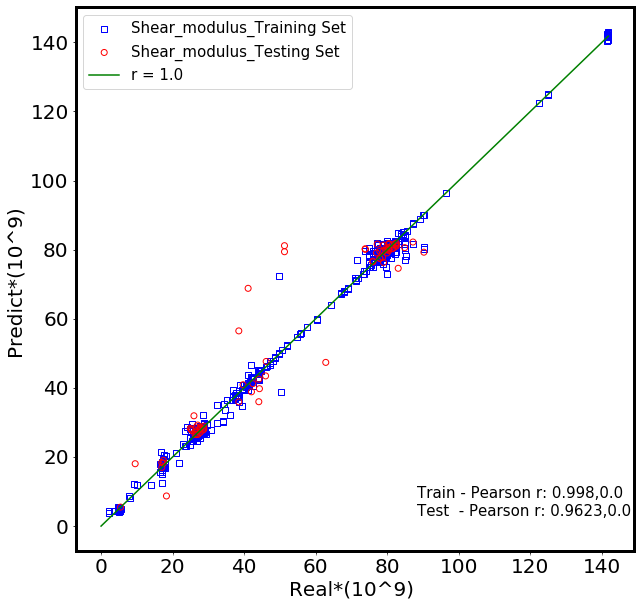

In [9]:
"""fitting (training) model(s)."""
Train_MAE = []
Test_MAE = []
Train_Pearson_r =[]
Test_Pearson_r = []
for HL in range(19,20): #(19,20)
    models = []
    """Build a neural network model"""
    layers = (HL,HL,HL,HL,HL,) #(HL,HL,HL,HL,HL,)
    act_func = 'relu'#'tanh'#'identity''logistic'
    if (len(mts_train) < 10000):
        mlp = MLPRegressor(hidden_layer_sizes=layers, solver='lbfgs', activation=act_func, max_iter=100000, tol=1e-6,early_stopping=True,verbose = False)
    else:
        mlp = MLPRegressor(hidden_layer_sizes=layers, solver='adam', activation=act_func, max_iter=10000, tol=1e-6)
    mlp.fit(features_train, targets_train)
    models.append(mlp)
    print('MLP with solver: {}'.format(mlp.solver))
    print("# of MLP iterations: {}".format(mlp.n_iter_))
    
    """Collecting data for better arrangement."""
    training_set = aggregate_data(mts_train, features_train, targets_train)
    testing_set  = aggregate_data(mts_test, features_test, targets_test)
    
    """Evaluation the results."""
    estimators = []
    estimators.append({'name':'{}'.format('MLP -     '), 'regressor':models[0]})
    print('\nResults of Training')    
    show_correlations(estimators, features_train, targets_train)
    
    """Cross validation."""
    k_fold = 10
    scores = []
    print('\n============= {}-Fold Cross Validation on Training Set =========='.format(k_fold))
    for estimator in estimators:
        score = cross_val_score(estimator['regressor'], features_train, targets_train, cv=k_fold)
        scores.append(score)
        print("{}: score = {} +- {}".format(estimator['name'], score.mean(), score.std()*2))
        display_cv(scores)
        print('\nResults of Testing')  
        show_correlations(estimators, features_test, targets_test)
        # show_elements_on_ptable([mts_test, mts_train])
    """Visualize the results."""
    for estimator in estimators:
    #    plot_regression_results(training_set, testing_set, estimator, print_details=True)
        def data4plotly_v2(training_set, testing_set, predictor):
            """Return python dicts(of training and testing set) for further plotly processing."""
            training_dict = dict()
            testing_dict  = dict()
            """Put the training set in to proper format"""
            training_dict['real']    = training_set['target']
            training_dict['predict'] = predictor.predict(training_set['feature'])
            training_dict['tag']     = ["Pretty:{}, Full:{}".format(mt['pretty_formula'], mt['full_formula']) for mt in training_set['mt']]
            """Put the training set in to proper format."""
            testing_dict['real']    = testing_set['target']
            testing_dict['predict'] = predictor.predict(testing_set['feature'])
            testing_dict['tag']     = ["Pretty:{}, Full:{}".format(mt['pretty_formula'], mt['full_formula']) for mt in testing_set['mt']]
            return training_dict, testing_dict
    
        def plot_regression_results_v2(training_set, testing_set, regressor, print_details = True):
            """Plot the regression results of training set, testing set."""
            def mae(v1, v2):
                """Return the MAE (mean absolute error) of v1 & v2."""
                return mean(abs((v1 - v2)/v2))*100
#    predicts_train = training_set['target'] - regressor['regressor'].predict(training_set['feature'])
#    predicts_test  = testing_set['target']  - regressor['regressor'].predict(testing_set['feature'])
            training, testing = data4plotly(training_set, testing_set, regressor['regressor'])
    
            if print_details:
                """export data"""
                print("{} Regressor".format(regressor['name']))
                print('Train - MAE: {}'.format(round(mae(training_set['target'], training['predict']),4)))
                print('Test  - MAE: {}'.format(round(mae(testing_set['target'], testing['predict']),4)))
                pearson_training=pearsonr(training_set['target'],training['predict'])
                print('Train - Pearson r: {},{}'.format(round(pearson_training[0],4),round(pearson_training[1],4)))
                #print('Train - Pearson r: {}'.format(pearsonr(training_set['target'], training['predict'])))
                pearson_testing=pearsonr(testing_set['target'],testing['predict'])
                print('Test  - Pearson r: {},{}'.format(round(pearson_testing[0],4),round(pearson_testing[1],4)))
                #print('Test  - Pearson r: {}'.format(pearsonr(testing_set['target'], testing['predict'])))
                Train_MAE.append(mae(training_set['target'], training['predict']))
                Test_MAE.append(mae(testing_set['target'], testing['predict']))
                Train_Pearson_r.append(pearsonr(training_set['target'], training['predict']))
                Test_Pearson_r.append(pearsonr(testing_set['target'], testing['predict']))
                
                """Loss Function"""
                #for i in range(1,(mlp.n_iter_)+1):
                    #print(mlp.loss_)
                    #print(i)
                
                """Plot Text"""
                Xorigin_pt = max(training['real'] + testing['real'])
                #if min(training['real']) < min(testing['real']) and min(training['real'])<min(training['predict']) and min(training['real'])<min(testing['predict']):
                    #Yorigin_pt = min(training['real'])
                #elif min(training['predict'])<min(training['real']) and min(training['predict'])<min(testing['real']) and min(training['predict'])<min(testing['predict']):
                    #Yorigin_pt = min(training['predict'])
                #elif min(testing['predict'])<min(training['predict']) and min(testing['predict'])<min(testing['real']) and min(testing['predict'])<min(training['predict']):
                    #Yorigin_pt = min(testing['predict'])
                #else:
                    #Yorigin_pt = min(testing['real'])
                plt.figure(figsize=(10, 10))
                #plt.text(Xorigin_pt-60,25,"{} Regressor".format(regressor['name']))
                #plt.text(Xorigin_pt-60,20,'Train - MAE: {}'.format(round(mae(training_set['target'], training['predict']),4)))
                #plt.text(Xorigin_pt-60,15,'Test  - MAE: {}'.format(round(mae(testing_set['target'], testing['predict']),4)))
                plt.text(Xorigin_pt-53.5,8,'Train - Pearson r: {},{}'.format(round(pearson_training[0],4),round(pearson_training[1],4)),size=15)
                plt.text(Xorigin_pt-53.5,3,'Test  - Pearson r: {},{}'.format(round(pearson_testing[0],4),round(pearson_testing[1],4)),size=15)
                
                training, testing = data4plotly_v2(training_set, testing_set, regressor['regressor'])
                plotly_pairing_set_v2(training, testing)
                
        def plotly_pairing_set_v2(training, testing):
            """Plot the training & testing sets."""
            Scatter1 = plt.scatter(training['real'],
                                   training['predict'],
                                   edgecolors='b',
                                   marker='s',
                                   facecolors='none'
                                   )

            Scatter2 =  plt.scatter(testing['real'],
                                    testing['predict'],
                                    edgecolors='r',
                                    marker='o',
                                    facecolors='none')
        
            """Ideal Curve"""
            end_pt = max(training['real'] + testing['real'])
            left_point = [0,end_pt]
            right_point = [0,end_pt]
            line, = plt.plot(left_point, right_point, 'g-')


            """Plot Details"""
            legendsize = {'size': 15}
            legend1 = '{}_Training Set'.format(MyTarget)
            legend2 = '{}_Testing Set'.format(MyTarget)
            plt.legend((Scatter1,Scatter2,line,),(legend1,legend2,'r = 1.0'),loc =2, prop=legendsize)
            #plt.title('Plot [Real] v.s. [Predict]')
            plt.xlabel('Real*(10^9) ',size=20)   # nm,μm,mm,cm,m 
            plt.ylabel('Predict*(10^9) ',size=20)  # nm,μm,mm,cm,m  
            #plt.xlabel('Real*{}'.format(units))
            #plt.ylabel('Predict*{}'.format(units))
            ax=plt.gca()
            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontsize(20)
                label.set_bbox(dict(facecolor='w',edgecolor='None',alpha=0.4))
            ax.spines['bottom'].set_linewidth(3)
            ax.spines['top'].set_linewidth(3)
            ax.spines['left'].set_linewidth(3)
            ax.spines['right'].set_linewidth(3)
            tick_params(which='major',length = 6,width=2)
            plt.xlim(0, end_pt+3)
            plt.ylim(0, end_pt+3)
            #plt.show()
            plt.savefig('{}_{}'.format(MyTarget,layers), dpi=600 )
            plt.cla()
        plot_regression_results_v2(training_set, testing_set, estimator, print_details=True)
    #print(HL)
    #print(layers)
    

In [ ]:
"""Export Data"""    
#print(Train_MAE)
#print(Test_MAE)
#print(Train_Pearson_r)
#print(Test_Pearson_r)
Train_Pearson_r_need,Train_Pearson_r_no = zip(*Train_Pearson_r)
Test_Pearson_r_need,Test_Pearson_r_no = zip(*Test_Pearson_r)
d = {'Train_MAE':Train_MAE, 
     'Test_MAE':Test_MAE,
     'Train_Pearson_r_need':Train_Pearson_r_need,
     'Train_Pearson_r_no':Train_Pearson_r_no,
     'Test_Pearson_r_need':Test_Pearson_r_need,
     'Test_Pearson_r_no':Test_Pearson_r_no
     }
df = pd.DataFrame(data = d)
#print(df)
np.savetxt('ML_{}_{}layers.txt'.format(MyTarget,len(layers)), df)